In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
# Define the file path instead of URL (since wget saves it locally)
file_path = "dataset_graph7.csv"

def visualize_counts(res_counts, num_qubits, num_shots):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = res_counts.get(0, 0.0)
    top_10 = dict(sorted(res_counts.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    yvals_prob = [yval / num_shots for yval in yvals]

    plt.bar(xvals, yvals_prob)
    plt.xticks(rotation=75)
    plt.title("Results of Sampling")
    plt.xlabel("Measured Bitstring")
    plt.ylabel("Probability")
    plt.show()

def get_training_data():
    """Read the training data from CSV."""
    url = "https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv"
    file_path = "dataset_graph7.csv"
    urllib.request.urlretrieve(url, file_path)
    df = pd.read_csv(file_path, sep=",", header=None)

    print("Data Preview:")
    print(df.head())  # Display first few rows

    # Ensure last column is numeric for sorting
    df.iloc[:, -1] = pd.to_numeric(df.iloc[:, -1], errors="coerce")

    # Take first 20 rows
    training_data = df.values[:20, :]  

    # Sort based on last column
    ind = np.argsort(training_data[:, -1])  
    X_train = training_data[ind][:, :-1]  # Exclude last column

    # Print required output format
    print(f"X_train shape: {X_train.shape}")
    print("X_train sample:\n", X_train[:5])  # Print first 5 rows

    return X_train

# Call function
X_train = get_training_data()

Data Preview:
         0         1         2         3         4         5         6   \
0 -0.193574  0.113979 -0.005927  0.300957 -0.358603 -0.087866 -0.156226   
1 -0.100006  0.002431  0.244218  0.126870 -0.063891 -0.085588  0.072490   
2 -1.774448 -0.047642 -0.025880  0.252708 -0.350689 -1.604509 -0.114874   
3 -0.211585 -0.043782 -1.560226  0.018510 -0.051867 -0.128508  0.218609   
4 -0.105965  0.208387 -0.003896  0.163816 -0.332541 -1.594675 -1.889321   

         7         8         9         10        11        12        13   14  
0  0.342442 -0.016003  0.143113  0.256422 -0.164125 -0.136743  0.014674  1.0  
1  0.042986 -0.052714  0.019754 -0.159314 -0.409991 -0.199615  0.053845 -1.0  
2  0.347631  0.059501 -0.168956  0.351014 -0.128586  0.098897 -0.047799  1.0  
3 -0.075632 -0.183656 -1.715292 -0.105361 -0.300758 -0.566431  0.046542 -1.0  
4 -0.251937  0.374445 -1.431062  0.290588  0.118851  0.048799 -0.073023  1.0  
X_train shape: (20, 14)
X_train sample:
 [[-1.66889314e+00  1

In [ ]:
# import sys
# sys.path.append(r"D:\Users\Tayyab Ali\Desktop\MyProjects\Quantum-Kernel-Training\env\Lib\site-packages")
# import pylatexenc
# print("pylatexenc is now recognized!")

pylatexenc is now recognized!


Data Preview:
         0         1         2         3         4         5         6   \
0 -0.193574  0.113979 -0.005927  0.300957 -0.358603 -0.087866 -0.156226   
1 -0.100006  0.002431  0.244218  0.126870 -0.063891 -0.085588  0.072490   
2 -1.774448 -0.047642 -0.025880  0.252708 -0.350689 -1.604509 -0.114874   
3 -0.211585 -0.043782 -1.560226  0.018510 -0.051867 -0.128508  0.218609   
4 -0.105965  0.208387 -0.003896  0.163816 -0.332541 -1.594675 -1.889321   

         7         8         9         10        11        12        13   14  
0  0.342442 -0.016003  0.143113  0.256422 -0.164125 -0.136743  0.014674  1.0  
1  0.042986 -0.052714  0.019754 -0.159314 -0.409991 -0.199615  0.053845 -1.0  
2  0.347631  0.059501 -0.168956  0.351014 -0.128586  0.098897 -0.047799  1.0  
3 -0.075632 -0.183656 -1.715292 -0.105361 -0.300758 -0.566431  0.046542 -1.0  
4 -0.251937  0.374445 -1.431062  0.290588  0.118851  0.048799 -0.073023  1.0  
X_train shape: (20, 14)
X_train sample:
 [[-1.66889314e+00  1

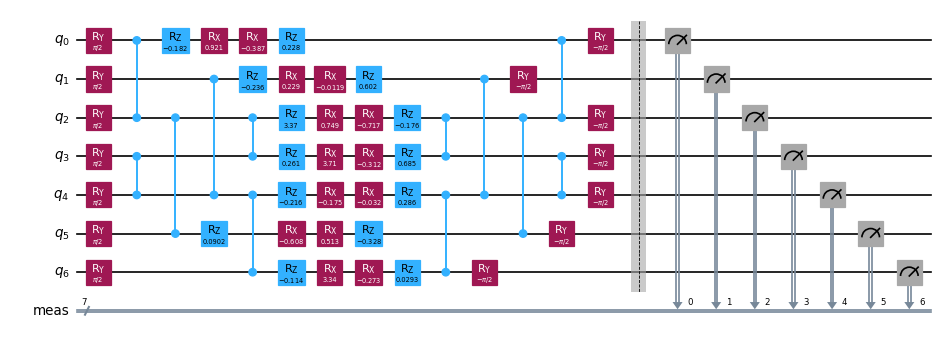

In [2]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import UnitaryOverlap
import pylatexenc
# Prepare training data
X_train = get_training_data()

# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

# Assign tunable parameter to known optimal value and set the data params for first two samples
x1 = 14
x2 = 19
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

# Create the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw("mpl", scale=0.6, style="iqp")

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save the API token securely
api_token = input("USE_YOUR_OWN_TOKEN")
QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_token, overwrite=True)

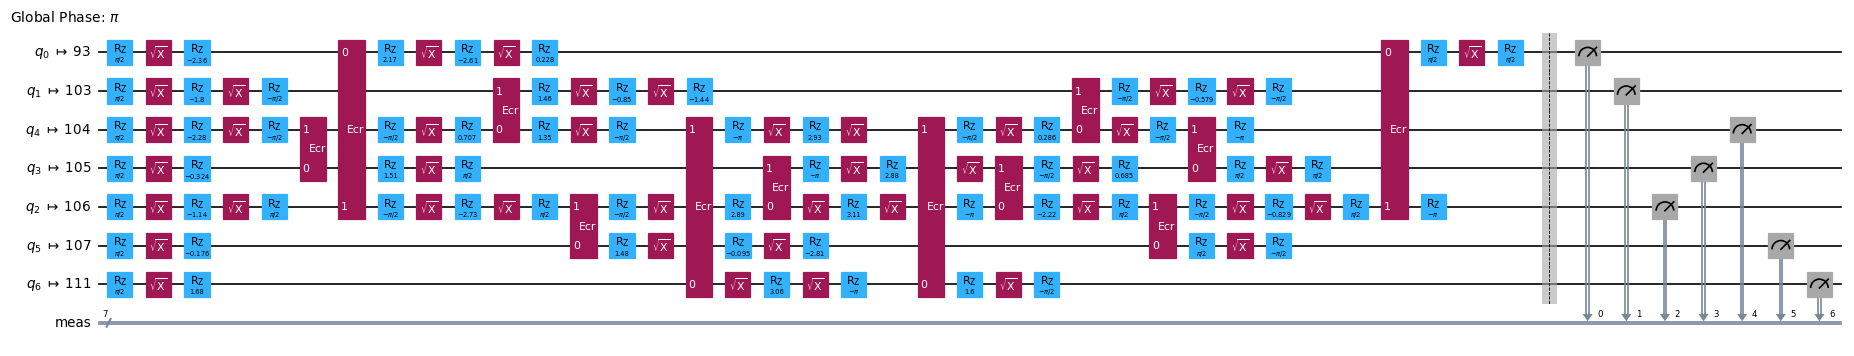

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService 

# Remember to insert your token in the QiskitRuntimeService constructor
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits
)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)
overlap_ibm.draw("mpl", scale=0.6, idle_wires=False, fold=-1, style="iqp")

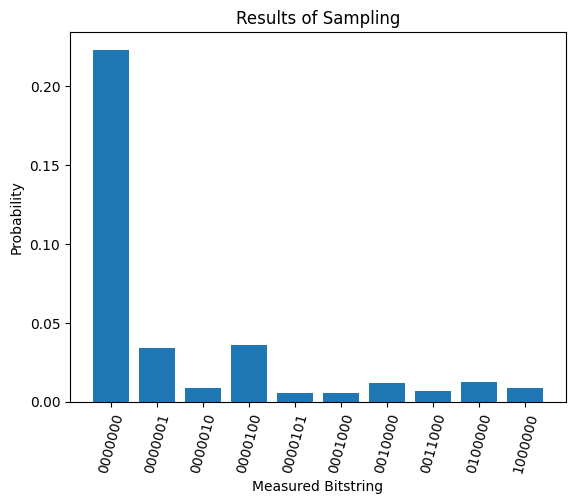

In [8]:
num_shots = 10_000

## Evaluate the problem using statevector-based primitives from Qiskit
#from qiskit.primitives import StatevectorSampler

#sampler = StatevectorSampler()
#results = sampler.run([overlap_circ]).result()
#counts = results[0].data.meas.get_int_counts()

# Evaluate the problem using a QPU via Qiskit IBM Runtime

from qiskit_ibm_runtime import Options, Sampler
sampler = Sampler(mode = backend)
results = sampler.run([overlap_ibm]).result()
counts = results[0].data.meas.get_int_counts()

visualize_counts(counts, num_qubits, num_shots)

In [9]:
# Calculate the fidelity, or the probability to measure 0
kernel_matrix[x1, x2] = counts.get(0, 0.0)/num_shots
print(f"Fidelity: {kernel_matrix[x1, x2]}")

Fidelity: 0.2232


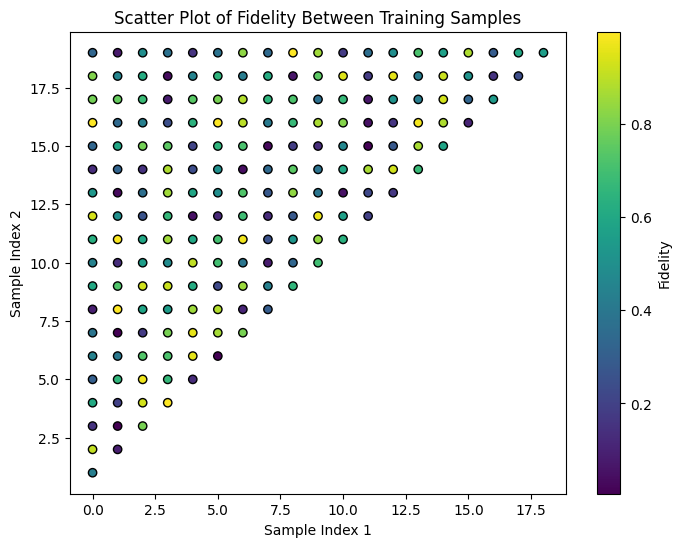

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Generate the fidelity data
num_samples = 20  # Number of training samples
kernel_matrix = np.random.random((num_samples, num_samples))  # Example fidelity matrix

# Get the indices and fidelity values
xvals, yvals, fidelity_values = [], [], []
for i in range(num_samples):
    for j in range(i + 1, num_samples):  # To avoid repetition (symmetric matrix)
        xvals.append(i)
        yvals.append(j)
        fidelity_values.append(kernel_matrix[i, j])  # Fidelity value between pair (i, j)

# Create the scatter plot with Matplotlib
plt.figure(figsize=(8, 6))
scatter = plt.scatter(xvals, yvals, c=fidelity_values, cmap="viridis", edgecolors="black")

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Fidelity")

# Labels and title
plt.xlabel("Sample Index 1")
plt.ylabel("Sample Index 2")
plt.title("Scatter Plot of Fidelity Between Training Samples")

# Show the plot
plt.show()